---
# NOTEBOOK 4 - SECOND-ROUND MODELING
---

# Project 3:
# 'Wait, was that a joke?' - Language Model Identification of Absurdist Humor and Satire
## Daniel Rossetti

# Problem Statement:
This project is conducted from the standpoint of a data scientist hired by a university researching the relatability of AI chat bots and their ability to identify nuances of human language, particularly humor.  Some statements are considered funny, but are not necessarily presented as a joke.  The task is to come up with a language model that can identify humorous strings of text which are not structed in the format of a joke but are of similar structure to factual information.  Text must sourced to train and test a model which can differentiate between humorous and non-humorous statements.

**Can an NLP model be trained to recognize satire or absurdist humor?**

# Project Approach:
The Onion is a satirical news organization which produces news titles and news stories often relevant to real, current events that are satirical or would otherwise be classified as absurdist humor.  For clarity **news articles and titles from The Onion are not real.**  The tiles are however, formated in the format of actual news titles and articles which, from legitimate news agencies - are not humorous.

Comparing the titles of posts to the subreddit r/TheOnion against the subreddit r/worldnews provides a way to compare strings of text which share many of the same formatting characteristics, but have completely different goals with respect to humor.

These subreddits are to be scraped and the data processed to see if a language model can idenifty the humorous Onion titles from the factual World News titles.

# Feature Engineering Approach
With the data now cleaned a few additional steps will be take prior to modeling:
* Word counts for each post will be examined
* Sentiment scores will be provided for each post
    * Sentiment may be useful in finding language in posts which is not neutral in tone.  This may serve to identify posts from The Onion which will stray from the use of neutral lanugage for the sake of satire or absurdism
* Subjectivity scores will also be examined:
    * Subjectivity in-essence describes when a post is opinion-based (subjective).  While best practices for legitimate news agencies are to use neutral language (objective), the words used in posts from The Onion may be more subjective in nature for the sake of satire or absurdism

If these features appear to be capable of increasing model perofrmance, they will be incorporated into the ensemble models.

# Modeling Approach

The final cleaned data output from the previous notebook will be imported and split into training and testing datasets.  The unseen 'holdout' data will also be imported and run alongside the models as a benchmmark.

The testing data created will be viewed after each model, and the information gained will be fed back to retrian the model or explore other features.  On it's own, this would create a dat leakage concenr, which is why the unseen data are provided to maintain the integrity of the modeling process, but also allow for retraining.



# CONTENT WARNING - INAPPROPRIATE LANGUAGE
The folowing should be noted before continuing with this notebook:
* The subreddit posts collected (and therefore shown or presented in these notebooks) may contian profanity or vulgarities, or be otherwise NSFW (Not Safe for Work) due to the fact that the posts are collected before the subreddit mderators can remove them, and that The Onion commonly uses this language for the sake of humor
* The subreddit posts were not generated by the author of this project/notebooks and do not represent his opinions


---
# 1 - Import Packages and Read Data

In [1]:
# STANDARD IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DATA PREP
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# LANGUAGE DATA PREP
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# MODELS:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              BaggingClassifier,
                              StackingClassifier)
from sklearn.neighbors import KNeighborsClassifier

# METRICS & VISUALIZATIONS
from sklearn.metrics import (ConfusionMatrixDisplay, 
                             confusion_matrix,
                             recall_score, 
                             precision_score,
                             f1_score)

from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

In [2]:
# Source to reset pandas column width:  https://pandas.pydata.org/docs/reference/api/pandas.reset_option.html
# Source to widen pandas columns:  https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.reset_option('all')
pd.set_option('display.max_colwidth', 200)

C:\Users\Dan\AppData\Local\Temp\ipykernel_844\2892979834.py:3: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option('all')
C:\Users\Dan\AppData\Local\Temp\ipykernel_844\2892979834.py:3: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option('all')
C:\Users\Dan\AppData\Local\Temp\ipykernel_844\2892979834.py:3: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option('all')


In [3]:
# Rad in the Modeling Data
reddit = pd.read_csv('../data/reddit_clean_2.csv')
reddit

,subreddit,title
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom
2,TheOnion,New Poll Finds Americans Would Respect Biden More If He Shot Them
3,TheOnion,Could You Pass Racial Discrimination Training At Fox News
4,TheOnion,Dog And Owner Having Public Fight
...,...,...
10043,worldnews,Diners in Japan arrested for dipping own chopsticks in communal bowl of ginger
10044,worldnews,200 Russian Journalists Sign Letter Demanding US Reporters Release
10045,worldnews,Foxconn founder Gou to run for Taiwan presidency again
10046,worldnews,A wartime NATO struggles to replace its chief


In [4]:
holdout = pd.read_csv('../data/reddit_holdout_2.csv')
holdout

,subreddit,title
0,TheOnion,US Schools Trail World In Child Soldier Aptitude
1,TheOnion,Is Your Flamingo Sick Enough To Make A Movie About
2,TheOnion,More American Workers Outsourcing Own Jobs Overseas
3,TheOnion,So People Could Be Listening To This Conversation Right Now Asks Joe Rogan Trying To Understand Edward Snowdens Explanation Of Surveillance
4,TheOnion,Destroyed substitute teachers
...,...,...
1722,worldnews,High level of activity spotted at North Koreas key nuclear complex
1723,worldnews,For the first time renewable energy generation beat out coal in the US
1724,worldnews,Chinas loans to Africa worry World Bank President David Malpass
1725,worldnews,In Ukraine where even the corpses are booby trapped Canada is helping soldiers stay alive


# 2 - Feature Engineering

## 2.1 - Word Counts

In [5]:
# Read in the Model Data
reddit = pd.read_csv('../data/reddit_clean_2.csv')
reddit

,subreddit,title
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom
2,TheOnion,New Poll Finds Americans Would Respect Biden More If He Shot Them
3,TheOnion,Could You Pass Racial Discrimination Training At Fox News
4,TheOnion,Dog And Owner Having Public Fight
...,...,...
10043,worldnews,Diners in Japan arrested for dipping own chopsticks in communal bowl of ginger
10044,worldnews,200 Russian Journalists Sign Letter Demanding US Reporters Release
10045,worldnews,Foxconn founder Gou to run for Taiwan presidency again
10046,worldnews,A wartime NATO struggles to replace its chief


In [6]:
# Read in the Holdout Data
holdout = pd.read_csv('../data/reddit_holdout_2.csv')
holdout

,subreddit,title
0,TheOnion,US Schools Trail World In Child Soldier Aptitude
1,TheOnion,Is Your Flamingo Sick Enough To Make A Movie About
2,TheOnion,More American Workers Outsourcing Own Jobs Overseas
3,TheOnion,So People Could Be Listening To This Conversation Right Now Asks Joe Rogan Trying To Understand Edward Snowdens Explanation Of Surveillance
4,TheOnion,Destroyed substitute teachers
...,...,...
1722,worldnews,High level of activity spotted at North Koreas key nuclear complex
1723,worldnews,For the first time renewable energy generation beat out coal in the US
1724,worldnews,Chinas loans to Africa worry World Bank President David Malpass
1725,worldnews,In Ukraine where even the corpses are booby trapped Canada is helping soldiers stay alive


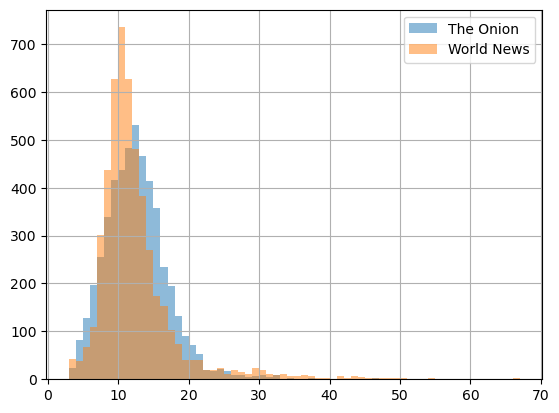

In [7]:
# Use a lambda funciton and the split method to get word counts
# Filter for each reddit and plot a histogram
onion_word_counts = reddit['title'].apply(lambda word: len(word.split(' ')))[reddit['subreddit'] == 'TheOnion']
wldnws_word_counts = reddit['title'].apply(lambda word: len(word.split(' ')))[reddit['subreddit'] == 'worldnews']

onion_word_counts.hist(alpha = 0.5, bins = (onion_word_counts.max() - onion_word_counts.min()));
wldnws_word_counts.hist(alpha = 0.5, bins = (wldnws_word_counts.max() - wldnws_word_counts.min()));
plt.legend(['The Onion', 'World News']);

In [8]:
onion_word_counts.describe(), wldnws_word_counts.describe()

(count    5043.000000
 mean       12.124727
 std         4.553454
 min         3.000000
 25%         9.000000
 50%        12.000000
 75%        15.000000
 max        50.000000
 Name: title, dtype: float64,
 count    5005.000000
 mean       12.014186
 std         5.874520
 min         3.000000
 25%         9.000000
 50%        11.000000
 75%        13.000000
 max        67.000000
 Name: title, dtype: float64)

In [9]:
# Create a separate dataframe to create word count column and encode the target variable
#  This way, it won't have to be undone later ... in retrospect, this was more work
word_count_tester = reddit
word_count_tester['w_counts'] = word_count_tester['title'].apply(lambda word: len(word.split(' ')))
word_count_tester['target'] = word_count_tester['subreddit'].map({'TheOnion': 1, 'worldnews':0})
word_count_tester.corr()

C:\Users\Dan\AppData\Local\Temp\ipykernel_844\1753397471.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  word_count_tester.corr()


,w_counts,target
w_counts,1.000000,0.010522
target,0.010522,1.000000


#### OBSERVATIONS:
* Average word counts are about the same for both The Onion and World News titles
* The World News titles have a more varried spread compared to The Onion.  This is reflected in both the standard deviation and the overall spread of the word counts
* There is little to no correlation between the word counts and the subreddit

Overall, the length of the title should have little to do with whether or not a title is funny, so there is really little justification to including this feature in the model. 

## 2.2 - Sentiment Analysis
It is possible that the word choice of Onion news titles may have more emotional verbiage for the sake of humor and satire.  By examining the compound sentiment scores for each title, it may be possible to determine if a title is from The Onion if the tiels have more emotional content.  Hihger sentiment scores indicate more positivity, and lower sentiment scores indicate more negativity with 0 being neutral.

In [10]:
# Instantiate Sentiment Analyzer
sent = SentimentIntensityAnalyzer()

# Create a column with the compound polarity score for each title
reddit['sentiment'] = reddit['title'].apply(lambda title: sent.polarity_scores(title)['compound'])
reddit.head()

,subreddit,title,w_counts,target,sentiment
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field,7,1,-0.5574
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom,17,1,0.5574
2,TheOnion,New Poll Finds Americans Would Respect Biden More If He Shot Them,12,1,0.4767
3,TheOnion,Could You Pass Racial Discrimination Training At Fox News,9,1,0.0000
4,TheOnion,Dog And Owner Having Public Fight,6,1,-0.3818


In [11]:
reddit[reddit['subreddit'] == 'TheOnion']['sentiment'].describe()

count    5043.000000
mean       -0.037135
std         0.409122
min        -0.947100
25%        -0.340000
50%         0.000000
75%         0.240100
max         0.937100
Name: sentiment, dtype: float64

In [12]:
reddit[reddit['subreddit'] == 'worldnews']['sentiment'].describe()

count    5005.000000
mean       -0.161563
std         0.402787
min        -0.969000
25%        -0.510600
50%         0.000000
75%         0.000000
max         0.963300
Name: sentiment, dtype: float64

In [13]:
reddit[['target', 'sentiment']].corr()

,target,sentiment
target,1.00000,0.15149
sentiment,0.15149,1.00000


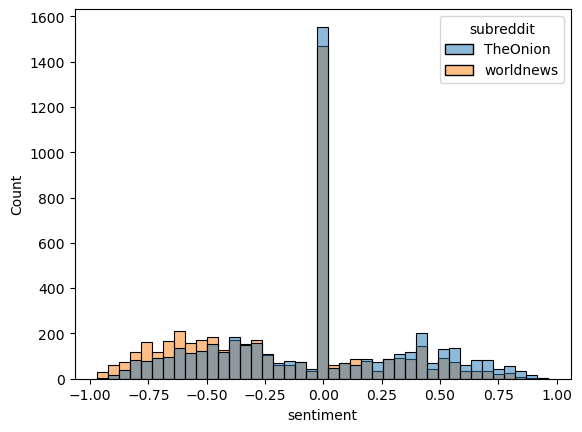

In [14]:
# Plot a histogram using seaborn
# Help with this from the following sourece:  https://seaborn.pydata.org/generated/seaborn.histplot.html
sns.histplot(reddit, x =reddit['sentiment'],  hue = 'subreddit');

#### OBSERVATIONS:
* The mean compound sentiment score for the world news titles are more negative than that of the Onion which interstingly, is closer to 0.  The opposite was thought to be true, that perhaps the actual news would have a more neutral delivery than The Onion
* Correlation between sentiment and the subreddit is very weak, but stronger than word counts

This feature should be included later in an ensemble model to determine if it would increase model performance

## <font color = 'red'> 2.3 - Subjectivity Analysis

# 3 - Pre-Modeling Steps

## 3.1 - Train Test Split 80/20 Split

In [15]:
# Create X and y variables

# Creating X - for now, this will only include the title data for ease of modeling
X = reddit['title']
y = reddit['target']

In [16]:
y.value_counts(normalize=True)

1    0.501891
0    0.498109
Name: target, dtype: float64

In [17]:
# Run the train test split, no need to stratify as classes are very even
#  Select an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

## 3.2 - Word Vectorizing - For Analysis Only

In [18]:
# Create a function to gather the most common words for each subreddit

def word_plotter(word_vec, X_var, y_var, num_words):
    
    # Create vectorized data
    X_train_cvec = word_vec.fit_transform(X_var)
    
    # Create dataframe from vecotrized data
    cvec_df = pd.DataFrame(X_train_cvec.todense(), columns = word_vec.get_feature_names_out())
    
    # Add the target variable to filer, but reset the index
    cvec_df['0000_target'] = y_var.reset_index(drop = True)
    
    # Plot it out!
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    cvec_df[cvec_df['0000_target'] == 0].drop(columns = '0000_target').sum().T.sort_values( ascending= True).tail(num_words).plot.barh();
    plt.title(f'World News {num_words} Most Common Words')
    plt.xlabel('Count')
    
    plt.subplot(1, 2, 2)
    cvec_df[cvec_df['0000_target'] == 1].drop(columns = '0000_target').sum().T.sort_values( ascending= True).tail(num_words).plot.barh();
    plt.title(f'The Onion {num_words} Most Common Words')
    plt.xlabel('Count')

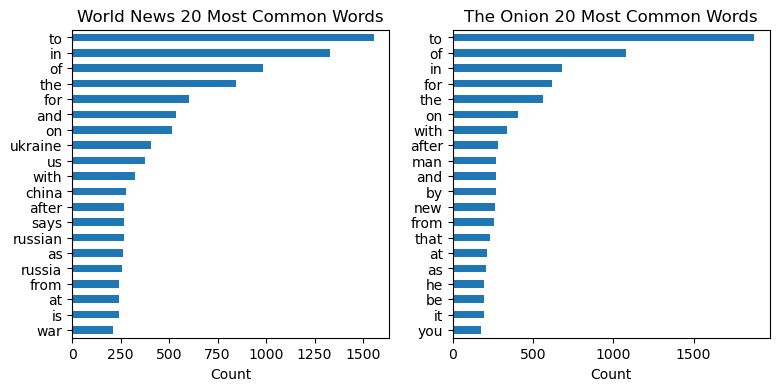

In [19]:
word_plotter(CountVectorizer(), X_train, y_train, 20)

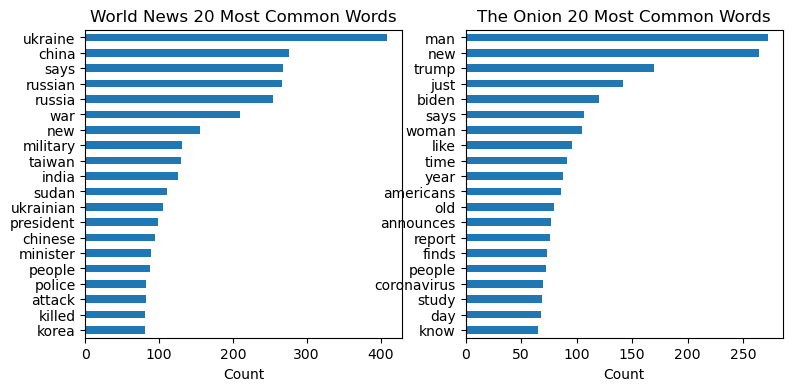

In [20]:
word_plotter(CountVectorizer(stop_words='english'), X_train, y_train, 20)

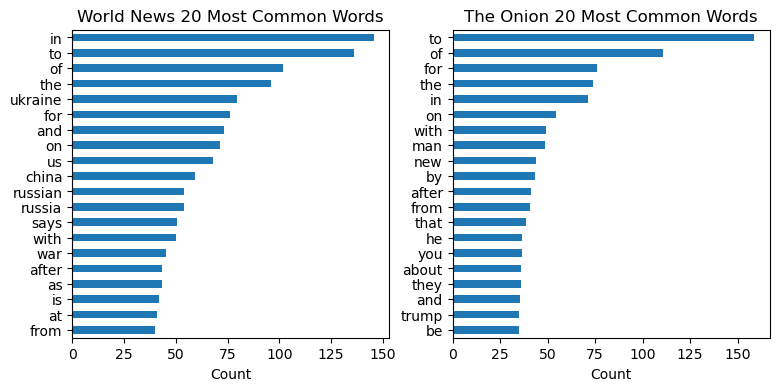

In [21]:
word_plotter(TfidfVectorizer(), X_train, y_train, 20)

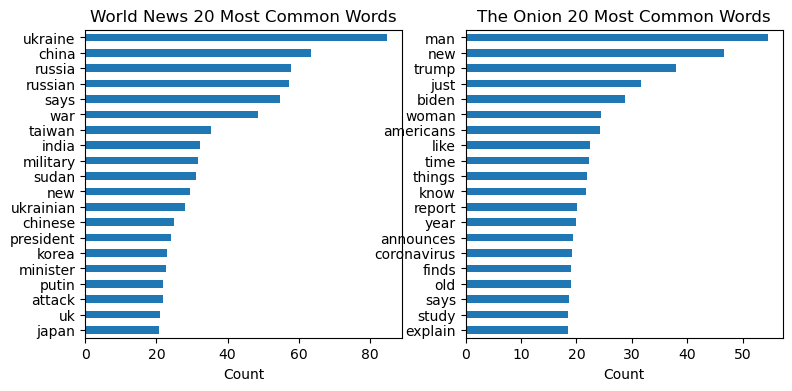

In [22]:
word_plotter(TfidfVectorizer(stop_words='english'), X_train, y_train, 20)

#### OBERSEVATIONS:
* The most popular words are generally stop words
* The top words in world news tend to be more world news focused as evidenced by the high counts of country names

#### Noted Sources of Error:
* In the word pre-processing, U.S. may have been shortened to 'us'.  When stop words are removed, this word is clearly missing from the plots
* The subject matter of current events may be better represented by the worldnews titles than by the onion.  While both subreddits have approximately the same number of samples, the activity of the worldnews subreddit is far higher than that of The Onion.  Title for world news go back to April 5 of 2023, while titles for The Onion go back all the way to January 3 of 2020.  In that time, the Ukraine war has happened, and content to that effect is being geenrated at a much fater rate on the World News subreddit than on The Onion.  Thus, the model may be able to pick out a new title solely by the content being discussed

## 3.3 - Create X and y for Holdout Data

In [23]:
X_hold = holdout['title']
y_hold = holdout['subreddit'].map({'TheOnion': 1, 'worldnews': 0})

In [24]:
y_hold.value_counts(normalize=True)

1    0.514765
0    0.485235
Name: subreddit, dtype: float64

# 4 - Modeling
* Seven varieties of classification models will first be run with default parameters to determine which types of model perform the best
* Then, the top models will be optimized via hyperparameter tuning

## Model Evaluation Metrics:
The accuracy of the model on both the testing and holdout data will be of paramount importance.  The problem statement inhernetly lends itself to being a pure accuracy problem.  There is no greater or lesser consequence for generating a false positive versus a false negative.  Thus, metrics such as precision and recall will not be deciding factors unless accuracies are highly comparable.  In this case, the f1 score could also be used, however, it may track very well with accuracy regardless.

## 4.1 - Default Parameter Modeling
This section will simply iterate through a suite of models to quickly understand which models appear to perform the best on the provided data.

### 4.1.1 - Define Metrics and Plotting Functions

In [25]:
def metrics_df(mods, X_1, y_1, X_2, y_2, X_3, y_3, mod_lab):
    list_dict = []

    for model in mods:
        mod_dict = {
            'Training Accuracy': model.score(X_1, y_1),
            'Training Recall': recall_score(model.predict(X_1), y_1),
            'Training Precision': precision_score(model.predict(X_1), y_1),
            'Training f1 score': f1_score(model.predict(X_1), y_1),
            'Testing Accuracy': model.score(X_2, y_2),
            'Testing Recall': recall_score(model.predict(X_2), y_2),
            'Testing Precision': precision_score(model.predict(X_2), y_2),
            'Testing f1 score': f1_score(model.predict(X_2), y_2),
            'Holdout Accuracy': model.score(X_3, y_3),
            'Holdout Recall': recall_score(model.predict(X_3), y_3),
            'Holdout Precision': precision_score(model.predict(X_3), y_3),
            'Holdout f1 score': f1_score(model.predict(X_3), y_3)
        }

        list_dict.append(mod_dict)
    return pd.DataFrame(list_dict, index=mod_lab)

In [26]:
# Define a funciton that does comparison plots!

def all_model_plotter(df1, df1_col, df1_label,
                      df2, df2_col, df2_label,
                      df3, df3_col, df3_label,
                      df4, df4_col, df4_label,
                      mod_labels, fig_size, ylim_12, ylim_34,
                      title_1, title_2
                     ):    #(df1, df1_col, df1_label, df2, df2_col, df2_label, mod_labels):

#plt.plot(pd.DataFrame(list_dict, index=class_models_labels))
# Source for assistance:  https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

    plt.figure(figsize=fig_size)

    plt.subplot(2, 1, 1)
    plt.title(title_1) #'Accuracy - Testing Data'
    plt.bar(x = mod_labels, 
            height=df1[df1_col], alpha = 0.5,
            width = .25,
            edgecolor ='grey',
           label = df1_label)
    plt.bar(x = mod_labels, 
            height=df2[df2_col], alpha = 0.5,
            width = .25,
            edgecolor ='grey',
           label = df2_label)
    plt.legend(loc = 'upper right')
    plt.yticks(np.arange(0,1.1,.05))  # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.yticks.html
    plt.ylim(ylim_12); # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html


    plt.subplot(2, 1, 2)
    plt.title(title_2) # 'Accuracy - Holdout Data'
    plt.bar(x = mod_labels, 
            height=df3[df3_col], alpha = 0.5,
            width = .25,
            edgecolor ='grey',
           label = df3_label)
    plt.bar(x = mod_labels, 
            height=df4[df4_col], alpha = 0.5, 
            width = .25,
            edgecolor ='grey',
           label = df4_label)
    plt.legend(loc = 'upper right')
    plt.yticks(np.arange(0,1.1,.05))  # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.yticks.html
    plt.ylim(ylim_34); # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html
    
    
    plt.subplots_adjust(hspace=0.3) #  Source:  https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/
    plt.show();

### 4.1.2 - Seven Candidate Models with CountVectorizer, With and Without Stopwords

In [27]:
# Define seven candidate classification models in pipelines with default parameters
log_pipe = Pipeline([
    ('cvc', CountVectorizer()),
    ('log_reg', LogisticRegression())
])

tree_pipe = Pipeline([
    ('cvc', CountVectorizer()),
    ('tree_class', DecisionTreeClassifier())
])

bag_pipe = Pipeline([
    ('cvc', CountVectorizer()),
    ('bag_class', BaggingClassifier())
])

rf_pipe = Pipeline([
    ('cvc', CountVectorizer()),
    ('rf_class', RandomForestClassifier())
])

ada_pipe = Pipeline([
    ('cvc', CountVectorizer()),
    ('ada_class', AdaBoostClassifier())
])

extra_pipe = Pipeline([
    ('cvc', CountVectorizer()),
    ('extra_tree', ExtraTreesClassifier())
])

grad_pipe = Pipeline([
    ('cvc', CountVectorizer()),
    ('grad', GradientBoostingClassifier())
])

In [28]:
# Define list of model instances to be run in loops going forward:
class_models = [log_pipe, tree_pipe, bag_pipe, rf_pipe, ada_pipe, extra_pipe, grad_pipe]

# Create list of names ot be used in functions going forward
class_models_labels = ['log_pipe', 'tree_pipe', 'bag_pipe', 'rf_pipe', 'ada_pipe', 'extra_pipe', 'grad_pipe']

In [29]:
# Loop through all instantiated models above to fit each of them
for model in class_models:
    model.fit(X_train, y_train)

# Run the Default Model Metrics funciton to get a dataframe of performance metrics on training, testing, and holdout data
def_mods_cvec = metrics_df(class_models, X_train, y_train, X_test, y_test, X_hold, y_hold, class_models_labels)

In [30]:
# Show the metrics dataframe tranposed for easier reading
def_mods_cvec.T

,log_pipe,tree_pipe,bag_pipe,rf_pipe,ada_pipe,extra_pipe,grad_pipe
Training Accuracy,0.987559,1.000000,0.985444,1.000000,0.776437,1.000000,0.802563
Training Recall,0.983752,1.000000,0.991213,1.000000,0.739644,1.000000,0.751700
Training Precision,0.991563,1.000000,0.979653,1.000000,0.855087,1.000000,0.905211
Training f1 score,0.987642,1.000000,0.985399,1.000000,0.793187,1.000000,0.821344
Testing Accuracy,0.885075,0.774129,0.809453,0.861194,0.764677,0.877612,0.793532
Testing Recall,0.876686,0.769527,0.815000,0.839815,0.730769,0.854764,0.750000
Testing Precision,0.898322,0.787759,0.804541,0.895360,0.844028,0.912142,0.885489
Testing f1 score,0.887372,0.778537,0.809737,0.866699,0.783326,0.882521,0.812132
Holdout Accuracy,0.855240,0.754488,0.778807,0.824551,0.717429,0.840185,0.742907
Holdout Recall,0.830403,0.738952,0.778266,0.786133,0.692234,0.800785,0.706592


In [31]:
# Define seven candidate classification models in pipelines with default parameters

#  THIS TIME - Set all stop words to 'english'

log_pipe = Pipeline([
    ('cvc', CountVectorizer(stop_words='english')),
    ('log_reg', LogisticRegression())
])

tree_pipe = Pipeline([
    ('cvc', CountVectorizer(stop_words='english')),
    ('tree_class', DecisionTreeClassifier())
])

bag_pipe = Pipeline([
    ('cvc', CountVectorizer(stop_words='english')),
    ('bag_class', BaggingClassifier())
])

rf_pipe = Pipeline([
    ('cvc', CountVectorizer(stop_words='english')),
    ('rf_class', RandomForestClassifier())
])

ada_pipe = Pipeline([
    ('cvc', CountVectorizer(stop_words='english')),
    ('ada_class', AdaBoostClassifier())
])

extra_pipe = Pipeline([
    ('cvc', CountVectorizer(stop_words='english')),
    ('extra_tree', ExtraTreesClassifier())
])

grad_pipe = Pipeline([
    ('cvc', CountVectorizer(stop_words='english')),
    ('grad', GradientBoostingClassifier())
])

In [32]:
# Loop through all instantiated models above to fit each of them
for model in class_models:
    model.fit(X_train, y_train)

# Run the Default Model Metrics funciton to get a dataframe of performance metrics on training, testing, and holdout data
def_mods_cvec_nsw = metrics_df(class_models, X_train, y_train, X_test, y_test, X_hold, y_hold, class_models_labels)

In [33]:
# Show the metrics dataframe tranposed for easier reading
def_mods_cvec_nsw.T

,log_pipe,tree_pipe,bag_pipe,rf_pipe,ada_pipe,extra_pipe,grad_pipe
Training Accuracy,0.987559,1.000000,0.984449,1.000000,0.776437,1.000000,0.803434
Training Recall,0.983752,1.000000,0.990455,1.000000,0.739644,1.000000,0.752058
Training Precision,0.991563,1.000000,0.978412,1.000000,0.855087,1.000000,0.906948
Training f1 score,0.987642,1.000000,0.984396,1.000000,0.793187,1.000000,0.822272
Testing Accuracy,0.885075,0.790547,0.799005,0.851244,0.764677,0.875124,0.790547
Testing Recall,0.876686,0.789628,0.806030,0.834897,0.730769,0.850184,0.747492
Testing Precision,0.898322,0.796644,0.791708,0.878578,0.844028,0.913129,0.882527
Testing f1 score,0.887372,0.793120,0.798805,0.856181,0.783326,0.880533,0.809416
Holdout Accuracy,0.855240,0.759699,0.783439,0.822235,0.717429,0.837290,0.741170
Holdout Recall,0.830403,0.754839,0.779587,0.788119,0.692234,0.799213,0.704251


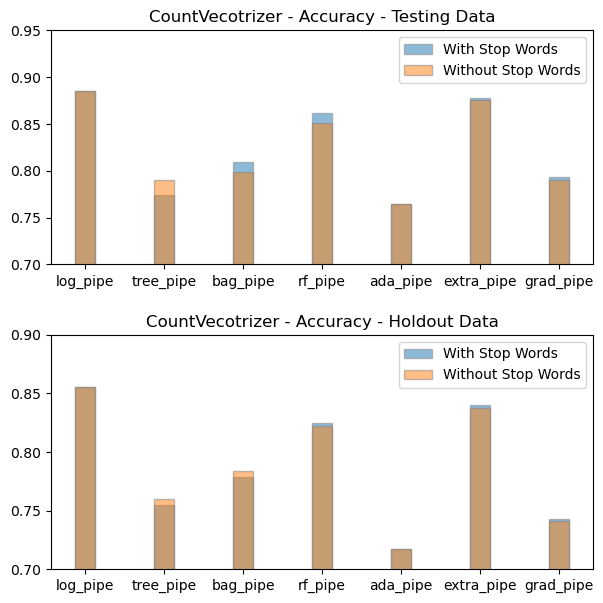

In [34]:
all_model_plotter(def_mods_cvec, 'Testing Accuracy', 'With Stop Words',
                  def_mods_cvec_nsw, 'Testing Accuracy', 'Without Stop Words',
                  def_mods_cvec, 'Holdout Accuracy', 'With Stop Words',
                  def_mods_cvec_nsw, 'Holdout Accuracy', 'Without Stop Words',
                  class_models_labels, (7,7), (0.7, 0.95), (0.7, 0.9),
                  'CountVecotrizer - Accuracy - Testing Data',
                  'CountVecotrizer - Accuracy - Holdout Data'
                 )

#### OBSERVATIONS:
* The best model is the logistic regression model for both the testing and holdout data
* All models except for the gradientboost and adaboost models are significantly overfit
    * Condering that the boosted models are much worse from an accuracy standpoint, the overfitting aspect is far less important here
    * For the other models, there is an opportunity to improve the performance on the testing and holdout datasets by trying to reduce overfitting
* It should be noted that the boosted models do have the highest precision scores:
    * This may make these models good candidates for use in stacking models later
* Removing stop words seems to improve model preformace in the lower performing models and causes a sligh degradation in performance of the logistic regression and extra trees models

### 4.1.2 - Seven Candidate Models with TFIDFVectorizer, With and Without Stopwords

In [35]:
# Define seven candidate classification models in pipelines with default parameters

log_pipe = Pipeline([
    ('tvc', TfidfVectorizer()),
    ('log_reg', LogisticRegression())
])

tree_pipe = Pipeline([
    ('tvc', TfidfVectorizer()),
    ('tree_class', DecisionTreeClassifier())
])

bag_pipe = Pipeline([
    ('tvc', TfidfVectorizer()),
    ('bag_class', BaggingClassifier())
])

rf_pipe = Pipeline([
    ('tvc', TfidfVectorizer()),
    ('rf_class', RandomForestClassifier())
])

ada_pipe = Pipeline([
    ('tvc', TfidfVectorizer()),
    ('ada_class', AdaBoostClassifier())
])

extra_pipe = Pipeline([
    ('tvc', TfidfVectorizer()),
    ('extra_tree', ExtraTreesClassifier())
])

grad_pipe = Pipeline([
    ('tvc', TfidfVectorizer()),
    ('grad', GradientBoostingClassifier())
])

In [36]:
# Loop through all instantiated models above to fit each of them
for model in class_models:
    model.fit(X_train, y_train)

# Run the Default Model Metrics funciton to stop_words=a dataframe of performance metrics on training, testing, and holdout data
def_mods_Tvec = metrics_df(class_models, X_train, y_train, X_test, y_test, X_hold, y_hold, class_models_labels)

In [37]:
# Show the metrics dataframe tranposed for easier reading
def_mods_Tvec.T

,log_pipe,tree_pipe,bag_pipe,rf_pipe,ada_pipe,extra_pipe,grad_pipe
Training Accuracy,0.987559,1.000000,0.984947,1.000000,0.776437,1.000000,0.805797
Training Recall,0.983752,1.000000,0.988259,1.000000,0.739644,1.000000,0.754169
Training Precision,0.991563,1.000000,0.981638,1.000000,0.855087,1.000000,0.908933
Training f1 score,0.987642,1.000000,0.984937,1.000000,0.793187,1.000000,0.824350
Testing Accuracy,0.885075,0.771642,0.810945,0.854229,0.764677,0.877114,0.788557
Testing Recall,0.876686,0.767892,0.813677,0.835821,0.730769,0.850091,0.746644
Testing Precision,0.898322,0.783810,0.810464,0.884501,0.844028,0.918065,0.878578
Testing f1 score,0.887372,0.775769,0.812067,0.859472,0.783326,0.882772,0.807256
Holdout Accuracy,0.855240,0.755067,0.784019,0.828025,0.717429,0.844818,0.746381
Holdout Recall,0.830403,0.742204,0.773885,0.796593,0.692234,0.804711,0.706691


In [38]:
# Define seven candidate classification models in pipelines with default parameters

# THIS TIME STOP WORDS = ENGLISH

log_pipe = Pipeline([
    ('tvc', TfidfVectorizer(stop_words='english')),
    ('log_reg', LogisticRegression())
])

tree_pipe = Pipeline([
    ('tvc', TfidfVectorizer(stop_words='english')),
    ('tree_class', DecisionTreeClassifier())
])

bag_pipe = Pipeline([
    ('tvc', TfidfVectorizer(stop_words='english')),
    ('bag_class', BaggingClassifier())
])

rf_pipe = Pipeline([
    ('tvc', TfidfVectorizer(stop_words='english')),
    ('rf_class', RandomForestClassifier())
])

ada_pipe = Pipeline([
    ('tvc', TfidfVectorizer(stop_words='english')),
    ('ada_class', AdaBoostClassifier())
])

extra_pipe = Pipeline([
    ('tvc', TfidfVectorizer(stop_words='english')),
    ('extra_tree', ExtraTreesClassifier())
])

grad_pipe = Pipeline([
    ('tvc', TfidfVectorizer(stop_words='english')),
    ('grad', GradientBoostingClassifier())
])

In [39]:
# Loop through all instantiated models above to fit each of them
for model in class_models:
    model.fit(X_train, y_train)

# Run the Default Model Metrics funciton to get a dataframe of performance metrics on training, testing, and holdout data
def_mods_Tvec_nsw = metrics_df(class_models, X_train, y_train, X_test, y_test, X_hold, y_hold, class_models_labels)

In [40]:
# Show the metrics dataframe tranposed for easier reading
def_mods_Tvec_nsw.T

,log_pipe,tree_pipe,bag_pipe,rf_pipe,ada_pipe,extra_pipe,grad_pipe
Training Accuracy,0.987559,1.000000,0.986315,1.000000,0.776437,1.000000,0.802687
Training Recall,0.983752,1.000000,0.990490,1.000000,0.739644,1.000000,0.750718
Training Precision,0.991563,1.000000,0.982134,1.000000,0.855087,1.000000,0.907940
Training f1 score,0.987642,1.000000,0.986295,1.000000,0.793187,1.000000,0.821878
Testing Accuracy,0.885075,0.775124,0.814428,0.858209,0.764677,0.876119,0.789552
Testing Recall,0.876686,0.774194,0.813725,0.841463,0.730769,0.855019,0.746244
Testing Precision,0.898322,0.781836,0.819348,0.885489,0.844028,0.908193,0.882527
Testing f1 score,0.887372,0.777996,0.816527,0.862915,0.783326,0.880804,0.808684
Holdout Accuracy,0.855240,0.763173,0.778228,0.824551,0.717429,0.841922,0.742907
Holdout Recall,0.830403,0.751572,0.769149,0.792415,0.692234,0.800195,0.704316


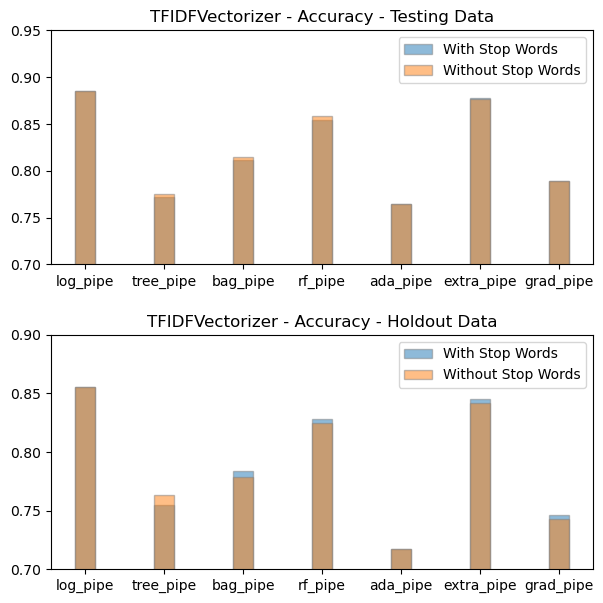

In [41]:
all_model_plotter(def_mods_Tvec, 'Testing Accuracy', 'With Stop Words',
                  def_mods_Tvec_nsw, 'Testing Accuracy', 'Without Stop Words',
                  def_mods_Tvec, 'Holdout Accuracy', 'With Stop Words',
                  def_mods_Tvec_nsw, 'Holdout Accuracy', 'Without Stop Words',
                  class_models_labels, (7,7), (0.7, 0.95), (0.7, 0.9),
                  'TFIDFVectorizer - Accuracy - Testing Data',
                  'TFIDFVectorizer - Accuracy - Holdout Data')

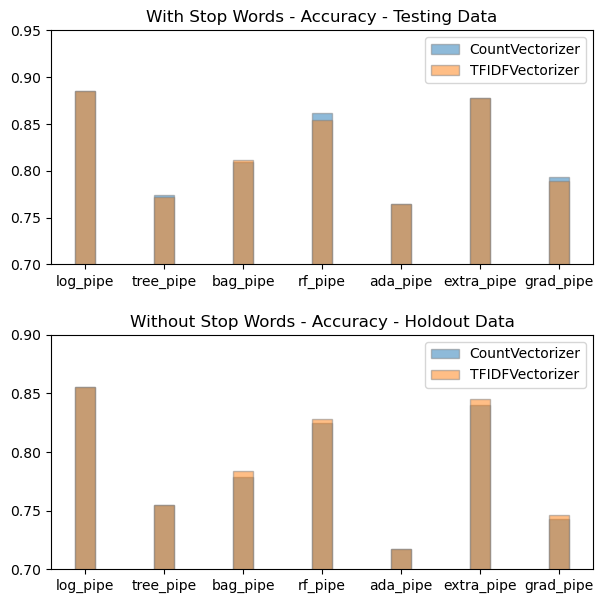

In [42]:
all_model_plotter(def_mods_cvec, 'Testing Accuracy', 'CountVectorizer',
                  def_mods_Tvec, 'Testing Accuracy', 'TFIDFVectorizer',
                  def_mods_cvec, 'Holdout Accuracy', 'CountVectorizer',
                  def_mods_Tvec, 'Holdout Accuracy', 'TFIDFVectorizer',
                  class_models_labels, (7,7), (0.7, 0.95), (0.7, 0.9),
                  'With Stop Words - Accuracy - Testing Data',
                  'Without Stop Words - Accuracy - Holdout Data')

#### OBSERVATIONS:
* _____

In [45]:
# Create a dataframe that ONLY shows accuracy scores for the testing and holdout data:
default_metrics_best = pd.concat([def_mods_cvec.T.loc[['Testing Accuracy', 'Holdout Accuracy']], 
           def_mods_cvec_nsw.T.loc[['Testing Accuracy', 'Holdout Accuracy']],
          def_mods_Tvec.T.loc[['Testing Accuracy', 'Holdout Accuracy']], 
           def_mods_Tvec_nsw.T.loc[['Testing Accuracy', 'Holdout Accuracy']]],
         )

# Create a column with eventual index names to then make that the column:
default_metrics_best['Vectorizer'] = ['Cvec Test Acc.', 'Cvec Hold Acc', 'Cvec NSW Test Acc.', 'Cvec NSW Hold Acc', 'Tvec Test Acc.', 'Tvec Hold Acc', 'Tvec NSW Test Acc.', 'Tvec NSW Hold Acc']

# Make the vectorizer Column the Index and...
# Highlight the highest values in each column green
#  Source:  # https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
default_metrics_best.set_index('Vectorizer').style.highlight_max(color = 'green', axis = 0)

,log_pipe,tree_pipe,bag_pipe,rf_pipe,ada_pipe,extra_pipe,grad_pipe
Vectorizer,,,,,,,
Cvec Test Acc.,0.885075,0.774129,0.809453,0.861194,0.764677,0.877612,0.793532
Cvec Hold Acc,0.855240,0.754488,0.778807,0.824551,0.717429,0.840185,0.742907
Cvec NSW Test Acc.,0.885075,0.790547,0.799005,0.851244,0.764677,0.875124,0.790547
Cvec NSW Hold Acc,0.855240,0.759699,0.783439,0.822235,0.717429,0.837290,0.741170
Tvec Test Acc.,0.885075,0.771642,0.810945,0.854229,0.764677,0.877114,0.788557
Tvec Hold Acc,0.855240,0.755067,0.784019,0.828025,0.717429,0.844818,0.746381
Tvec NSW Test Acc.,0.885075,0.775124,0.814428,0.858209,0.764677,0.876119,0.789552
Tvec NSW Hold Acc,0.855240,0.763173,0.778228,0.824551,0.717429,0.841922,0.742907


#### OBSERVATIONS:
* _____

### 4.1.3 - MODEL DOWN-SELECT:
Given the performance numbers above the following three models will be carried forward for further optimization:
* Logistic Regression
* Random Forest Classifier
* Extra Trees Classifier

## 4.2 - Notes on Model Optimization with Hyperparameter Tuning
* Every combination of hyperparameter that was examined through multiple runs will NOT be shown
* Instead, the hyperparameter values in the gridsearches shown below will contain values at or around the optimal values
* The obersavations below each optimized model will state what trends lead to the selection of the gridsearch parameters shown

## 4.3 - Logistic Regression Model Optimization

In [ ]:
log_pipe_opt = Pipeline([
    ('cvc', CountVectorizer()),
    ('log_reg', LogisticRegression())
])

In [323]:
log_params = {
    'cvc__max_features' : [3000, 10_000, None],
    'cvc__min_df' : [1, 2, 4],
    'cvc__max_df' : [1.0, 0.9],
    'cvc__ngram_range' : [(1, 1), (1,2), (1,3)],
    'log_reg__C': [1.2, 1.1, 1, 0.9],
    'log_reg__n_jobs': [-1]
}

In [324]:
gs_log = GridSearchCV(log_pipe_opt,
                     log_params,
                     cv = 5, error_score='raise')

In [325]:
%%time
gs_log.fit(X_train, y_train)
gs_log.best_params_, gs_log.best_score_

CPU times: total: 5min 28s
Wall time: 9min 31s


({'cvc__max_df': 1.0,
  'cvc__max_features': None,
  'cvc__min_df': 1,
  'cvc__ngram_range': (1, 2),
  'log_reg__C': 1.2,
  'log_reg__n_jobs': -1},
 0.8875347128699997)

In [326]:
gs_log.score(X_train, y_train), gs_log.score(X_test, y_test), gs_log.score(X_hold, y_hold)

(0.9997511818860413, 0.891044776119403, 0.8598726114649682)

#### OBSERVATIONS:

##### <u>Hyperparameter Trends:</u>
* Max features likes to include all features, setting is 'None'
* Min_df likes being as low as possible, setting is 1
* Max_df likes to include all features, setting is 1.0
* N_grams likes to include bigrams, but not any higher word-grams, setting is (1,2)
* C likes being 1

##### <u>Optimization Results:</u>
* The best parameters above have inceased the accuracy on the testing dataset from 88.4% to 89.1%, and on the holdout dataset from 85.4% to 86.0%


## 4.4 - Random Forest Classifier Model Optimization

In [ ]:
# rf_params = {
#     'cvc__max_features' : [3000, 10_000, None],
#     'cvc__min_df' : [1, 2, 4],
#     'cvc__max_df' : [1.0, 0.9],
#     'cvc__ngram_range' : [(1, 1), (1,2), (1,3)],
#     'rf_class__n_estimators': [20, 50, 100],
#     'rf_class__max_depth': [10, 30, 50],
#     'rf_class__n_jobs': [-1]
# }

RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)


In [ ]:
%%time
rf_pipe_opt = Pipeline([
    ('tvc', TfidfVectorizer()),
    ('rf_class', RandomForestClassifier())
])

rf_params = {
    'tvc__max_features' : [3000, 10_000],
    'tvc__min_df' : [1, 2, 4],
    'tvc__max_df' : [1.0, 0.9],
    'tvc__ngram_range' : [(1, 1)],
    'rf_class__n_estimators': [20, 50],
    'rf_class__max_depth': [10, 30],
    'rf_class__n_jobs': [-1]
}

gs_log = GridSearchCV(rf_pipe_opt,
                     rf_params,
                     cv = 5, error_score='raise')

In [ ]:
CountVectorizer

---
# JUNK

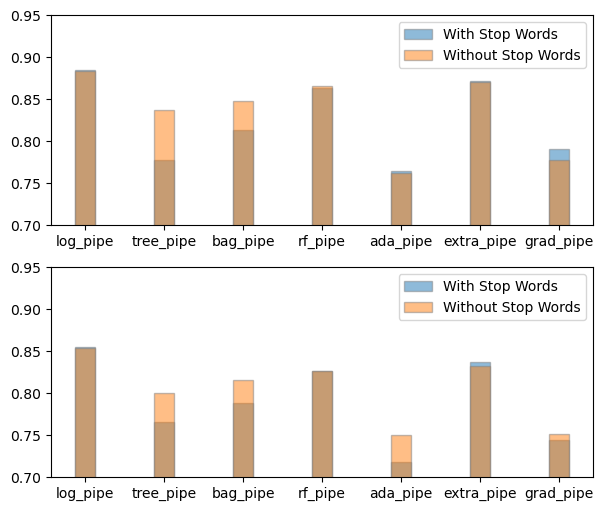

In [258]:
#plt.plot(pd.DataFrame(list_dict, index=class_models_labels))
# Source for assistance:  https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

plt.figure(figsize=(7, 6))

plt.subplot(2, 1, 1)
plt.bar(x = class_models_labels, 
        height=met_cvec['Testing Accuracy'], alpha = 0.5,
        width = .25,
        edgecolor ='grey',
       label = 'With Stop Words')
plt.bar(x = class_models_labels, 
        height=met_cvec_sw['Testing Accuracy'], alpha = 0.5,
        width = .25,
        edgecolor ='grey',
       label = 'Without Stop Words')
plt.legend(loc = 'upper right')
plt.yticks(np.arange(0,1.1,.05))  # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.yticks.html
plt.ylim(0.7, .95); # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html


plt.subplot(2, 1, 2)
plt.bar(x = class_models_labels, 
        height=met_cvec['Holdout Accuracy'], alpha = 0.5,
        width = .25,
        edgecolor ='grey',
       label = 'With Stop Words')
plt.bar(x = class_models_labels, 
        height=met_cvec_sw['Holdout Accuracy'], alpha = 0.5, 
        width = .25,
        edgecolor ='grey',
       label = 'Without Stop Words')
plt.legend(loc = 'upper right')
plt.yticks(np.arange(0,1.1,.05))  # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.yticks.html
plt.ylim(0.7, 0.95); # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html

In [237]:
list_dict = []

for model in class_models:
    mod_dict = {
        'Training Accuracy': model.score(X_train, y_train),
        'Training Recall': recall_score(model.predict(X_train), y_train),
        'Training Precision': precision_score(model.predict(X_train), y_train),
        'Training f1 score': f1_score(model.predict(X_train), y_train),
        'Testing Accuracy': model.score(X_test, y_test),
        'Testing Recall': recall_score(model.predict(X_test), y_test),
        'Testing Precision': precision_score(model.predict(X_test), y_test),
        'Testing f1 score': f1_score(model.predict(X_test), y_test),
        'Holdout Accuracy': model.score(X_hold, y_hold),
        'Holdout Recall': recall_score(model.predict(X_hold), y_hold),
        'Holdout Precision': precision_score(model.predict(X_hold), y_hold),
        'Holdout f1 score': f1_score(model.predict(X_hold), y_hold)
    }
    
    list_dict.append(mod_dict)

In [238]:
class_models_labels = ['log_pipe', 'tree_pipe', 'bag_pipe', 'rf_pipe', 'ada_pipe', 'extra_pipe', 'grad_pipe']
met_cvec = pd.DataFrame(list_dict, index=class_models_labels)
met_cvec.T

# https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
#.style.highlight_max(color = 'lightgreen', axis = 0)

,log_pipe,tree_pipe,bag_pipe,rf_pipe,ada_pipe,extra_pipe,grad_pipe
Training Accuracy,0.987559,1.000000,0.985569,1.000000,0.776437,1.000000,0.803060
Training Recall,0.983752,1.000000,0.992947,1.000000,0.739644,1.000000,0.752008
Training Precision,0.991563,1.000000,0.978164,1.000000,0.855087,1.000000,0.905955
Training f1 score,0.987642,1.000000,0.985500,1.000000,0.793187,1.000000,0.821835
Testing Accuracy,0.885075,0.778109,0.813433,0.863682,0.764677,0.871144,0.790050
Testing Recall,0.876686,0.775510,0.826176,0.844362,0.730769,0.845238,0.747695
Testing Precision,0.898322,0.787759,0.797631,0.894373,0.844028,0.911155,0.880553
Testing f1 score,0.887372,0.781587,0.811652,0.868648,0.783326,0.876960,0.808704
Holdout Accuracy,0.855240,0.766068,0.788072,0.826867,0.717429,0.836711,0.744644
Holdout Recall,0.830403,0.759914,0.785169,0.793241,0.692234,0.795521,0.707024


In [369]:
class_models = [log_pipe, tree_pipe, bag_pipe, rf_pipe, ada_pipe, extra_pipe, grad_pipe]

for model in class_models:
    model.fit(X_train, y_train)

In [371]:
list_dict = []

for model in class_models:
    mod_dict = {
        #'---TRAINING---': '-',
        'Training Accuracy': model.score(X_train, y_train),
        'Training Recall': recall_score(model.predict(X_train), y_train),
        'Training Precision': precision_score(model.predict(X_train), y_train),
        'Training f1 score': f1_score(model.predict(X_train), y_train),
        #'---TESTING---': '-',
        'Testing Accuracy': model.score(X_test, y_test),
        'Testing Recall': recall_score(model.predict(X_test), y_test),
        'Testing Precision': precision_score(model.predict(X_test), y_test),
        'Testing f1 score': f1_score(model.predict(X_test), y_test),
        #'---HOLDOUT---': '-',
        'Holdout Accuracy': model.score(X_hold, y_hold),
        'Holdout Recall': recall_score(model.predict(X_hold), y_hold),
        'Holdout Precision': precision_score(model.predict(X_hold), y_hold),
        'Holdout f1 score': f1_score(model.predict(X_hold), y_hold)
    }
    
    list_dict.append(mod_dict)

In [372]:
class_models_labels = ['log_pipe', 'tree_pipe', 'bag_pipe', 'rf_pipe', 'ada_pipe', 'extra_pipe', 'grad_pipe']
met_cvec_sw = pd.DataFrame(list_dict, index=class_models_labels)
met_cvec_sw.T
# https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
#.style.highlight_max(color = 'lightgreen', axis = 0)

,log_pipe,tree_pipe,bag_pipe,rf_pipe,ada_pipe,extra_pipe,grad_pipe
Training Accuracy,0.985569,1.000000,0.987684,1.000000,0.775690,1.000000,0.801568
Training Recall,0.980599,1.000000,0.987596,1.000000,0.706548,1.000000,0.722618
Training Precision,0.990819,1.000000,0.987841,1.000000,0.945161,1.000000,0.980645
Training f1 score,0.985683,1.000000,0.987719,1.000000,0.808619,1.000000,0.832088
Testing Accuracy,0.883582,0.831343,0.843781,0.866169,0.762189,0.867164,0.782090
Testing Recall,0.867800,0.820342,0.829406,0.840659,0.697417,0.851887,0.711553
Testing Precision,0.907206,0.851925,0.868707,0.906219,0.932873,0.891412,0.954590
Testing f1 score,0.887066,0.835835,0.848602,0.872209,0.798142,0.871201,0.815346
Holdout Accuracy,0.854082,0.800811,0.809496,0.833816,0.749855,0.833237,0.757383
Holdout Recall,0.815659,0.773320,0.778884,0.788868,0.689627,0.798411,0.689516


In [381]:
def metrics_df(mods, X_1, y_1, X_2, y_2, X_3, y_3, mod_lab):
    list_dict = []

    for model in mods:
        mod_dict = {
            'Training Accuracy': model.score(X_1, y_1),
            'Training Recall': recall_score(model.predict(X_1), y_1),
            'Training Precision': precision_score(model.predict(X_1), y_1),
            'Training f1 score': f1_score(model.predict(X_1), y_1),
            'Testing Accuracy': model.score(X_2, y_2),
            'Testing Recall': recall_score(model.predict(X_2), y_2),
            'Testing Precision': precision_score(model.predict(X_2), y_2),
            'Testing f1 score': f1_score(model.predict(X_2), y_2),
            'Holdout Accuracy': model.score(X_3, y_3),
            'Holdout Recall': recall_score(model.predict(X_3), y_3),
            'Holdout Precision': precision_score(model.predict(X_3), y_3),
            'Holdout f1 score': f1_score(model.predict(X_3), y_3)
        }

        list_dict.append(mod_dict)
    return pd.DataFrame(list_dict, index=mod_lab)

In [382]:
class_models_labels = ['log_pipe', 'tree_pipe', 'bag_pipe', 'rf_pipe', 'ada_pipe', 'extra_pipe', 'grad_pipe']

metrics_df(class_models, X_train, y_train, X_test, y_test, X_hold, y_hold, class_models_labels)

,Training Accuracy,Training Recall,Training Precision,Training f1 score,Testing Accuracy,Testing Recall,Testing Precision,Testing f1 score,Holdout Accuracy,Holdout Recall,Holdout Precision,Holdout f1 score
log_pipe,0.985569,0.980599,0.990819,0.985683,0.883582,0.867800,0.907206,0.887066,0.854082,0.815659,0.925759,0.867229
tree_pipe,1.000000,1.000000,1.000000,1.000000,0.831343,0.820342,0.851925,0.835835,0.800811,0.773320,0.867267,0.817603
bag_pipe,0.987684,0.987596,0.987841,0.987719,0.843781,0.829406,0.868707,0.848602,0.809496,0.778884,0.879640,0.826202
rf_pipe,1.000000,1.000000,1.000000,1.000000,0.866169,0.840659,0.906219,0.872209,0.833816,0.788868,0.924634,0.851372
ada_pipe,0.775690,0.706548,0.945161,0.808619,0.762189,0.697417,0.932873,0.798142,0.749855,0.689627,0.934758,0.793696
extra_pipe,1.000000,1.000000,1.000000,1.000000,0.867164,0.851887,0.891412,0.871201,0.833237,0.798411,0.904387,0.848101
grad_pipe,0.801568,0.722618,0.980645,0.832088,0.782090,0.711553,0.954590,0.815346,0.757383,0.689516,0.961755,0.803194


In [ ]:
all_model_plotter(met_cvec, 'Testing Accuracy', 'With Stop Words',
                  met_cvec_sw, 'Testing Accuracy', 'Without Stop Words',
                  met_cvec, 'Holdout Accuracy', 'With Stop Words',
                  met_cvec_sw, 'Holdout Accuracy', 'Without Stop Words',
                  class_models_labels, (7,7), (0.7, 0.95), (0.7, 0.9))

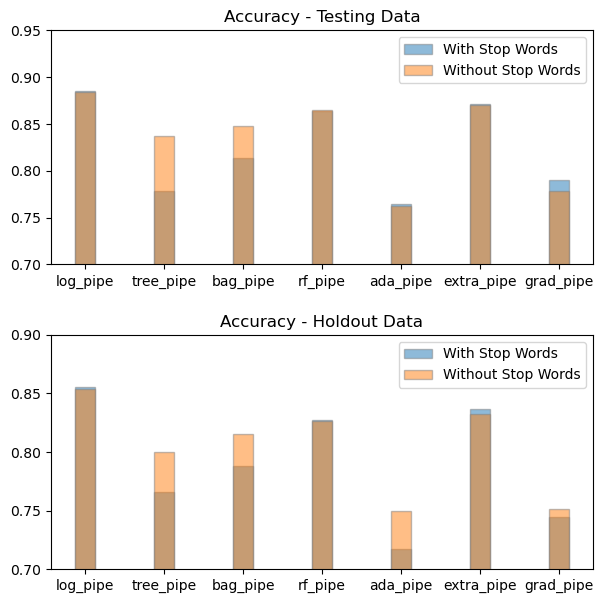

In [360]:
# Define a funciton that does comparison plots!

def all_model_plotter(df1, df1_col, df1_label,
                      df2, df2_col, df2_label,
                      df3, df3_col, df3_label,
                      df4, df4_col, df4_label,
                      mod_labels, fig_size, ylim_12, ylim_34):    #(df1, df1_col, df1_label, df2, df2_col, df2_label, mod_labels):

#plt.plot(pd.DataFrame(list_dict, index=class_models_labels))
# Source for assistance:  https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

    plt.figure(figsize=fig_size)

    plt.subplot(2, 1, 1)
    plt.title('Accuracy - Testing Data')
    plt.bar(x = mod_labels, 
            height=df1[df1_col], alpha = 0.5,
            width = .25,
            edgecolor ='grey',
           label = df1_label)
    plt.bar(x = mod_labels, 
            height=df2[df2_col], alpha = 0.5,
            width = .25,
            edgecolor ='grey',
           label = df2_label)
    plt.legend(loc = 'upper right')
    plt.yticks(np.arange(0,1.1,.05))  # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.yticks.html
    plt.ylim(ylim_12); # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html


    plt.subplot(2, 1, 2)
    plt.title('Accuracy - Holdout Data')
    plt.bar(x = mod_labels, 
            height=df3[df3_col], alpha = 0.5,
            width = .25,
            edgecolor ='grey',
           label = df3_label)
    plt.bar(x = mod_labels, 
            height=df4[df4_col], alpha = 0.5, 
            width = .25,
            edgecolor ='grey',
           label = df4_label)
    plt.legend(loc = 'upper right')
    plt.yticks(np.arange(0,1.1,.05))  # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.yticks.html
    plt.ylim(ylim_34); # Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html
    
    
    plt.subplots_adjust(hspace=0.3) #  Source:  https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/
    plt.show();
    
all_model_plotter(met_cvec, 'Testing Accuracy', 'With Stop Words',
                  met_cvec_sw, 'Testing Accuracy', 'Without Stop Words',
                  met_cvec, 'Holdout Accuracy', 'With Stop Words',
                  met_cvec_sw, 'Holdout Accuracy', 'Without Stop Words',
                  class_models_labels, (7,7), (0.7, 0.95), (0.7, 0.9))